In [113]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 199 kB/s 
     |████████████████████████████████| 13.1 MB 15.7 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=71c36d33787130508b546fb2934ae2b3d9fcb145b3cce7d080dc9a1d1091e7d1
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [137]:
!pip install lime

     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=da1bed775697f0216421ca3ea6230a3a871c76b7905295a39bcf87702714386c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
from xgboost import XGBClassifier
from pandas_profiling import ProfileReport
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import datetime as dt 
from sklearn.linear_model import LogisticRegression

In [25]:
import warnings
warnings.filterwarnings("ignore")

# Dataset Description

In [3]:
df = pd.read_csv('all_churn_customer.csv', index_col=0)

In [4]:
#types
types_set = set(df.dtypes)
types_dict = {k:v for k, v in zip(types_set, [0,0,0])}
for _type in df.dtypes:
    types_dict[_type] += 1
print(types_dict)

{dtype('int64'): 254, dtype('O'): 1, dtype('float64'): 11}


In [5]:
#statistics
df.describe()

,count_transaction,schedule_service,count_items,total_spend,total_credit,total_vol,total_weight,scheduled_price,Service_Code_Unit_of_Measure_ADJ,Service_Code_Unit_of_Measure_EA,Service_Code_Unit_of_Measure_HR,Service_Code_Unit_of_Measure_KG,Service_Code_Unit_of_Measure_KLT,Service_Code_Unit_of_Measure_LTR,Service_Code_Unit_of_Measure_M3,Service_Code_Unit_of_Measure_TON,Service_Lift_Type_Front Lift,Service_Lift_Type_RORO,Service_Lift_Type_Rear Lift,Service_Waste_Stream_Co-Mingle,Service_Waste_Stream_General Waste,Service_Waste_Stream_Organic,Service_Waste_Stream_Recycling,Activity_Name_C&I,Activity_Name_Liquid,Activity_Name_Rebate,Activity_Name_Sale of Other,month_count,recency,weight_per_unit,Frequency_per_month,Spend_per_month,ATV,UPT,ASP,AWT,AVT,WPF_Flag,LPF_Flag,OCF_Flag,...,Sub_Banding_National,Sub_Banding_SME,Sub_Banding_TFA,Sub_Banding_Unassigned,Sub_Banding_X,Sub_Banding_nan,Uprate_Category_COMP,Uprate_Category_EXEM,Uprate_Category_F1Y,Uprate_Category_F2Y,Uprate_Category_F3Y,Uprate_Category_GEN,Uprate_Category_KAM,Uprate_Category_LOC,Uprate_Category_NAT,Uprate_Category_RESI,Uprate_Category_SPEC,Uprate_Category_STA,Uprate_Category_U6%,Uprate_Category_nan,ANZSIC_Division_Accommodation and Food Services,ANZSIC_Division_Administrative and Support Services,"ANZSIC_Division_Agriculture, Forestry and Fishing",ANZSIC_Division_Arts and Recreation Services,ANZSIC_Division_Construction,ANZSIC_Division_Education and Training,"ANZSIC_Division_Electricity, Gas, Water and Waste Services",ANZSIC_Division_Financial and Insurance Services,ANZSIC_Division_Health Care and Social Assistance,ANZSIC_Division_Information Media and Telecommunications,ANZSIC_Division_Manufacturing,ANZSIC_Division_Mining,ANZSIC_Division_Other Services,"ANZSIC_Division_Professional, Scientific and Technical Services",ANZSIC_Division_Public Administration and Safety,"ANZSIC_Division_Rental, Hiring and Real Estate Services",ANZSIC_Division_Retail Trade,"ANZSIC_Division_Transport, Postal and Warehousing",ANZSIC_Division_Wholesale Trade,ANZSIC_Division_nan
count,884.000000,884.000000,884.000000,8.840000e+02,8.840000e+02,884.000000,8.840000e+02,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,...,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.0,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000
mean,222.572398,222.572398,2217.006638,1.367686e+04,1.341499e+04,699.767170,2.730197e+04,5839.954759,0.134615,65.231900,0.487557,5.113122,0.002262,0.523756,139.055430,12.023756,76.851810,13.717195,66.569005,17.674208,100.475113,1.321267,37.667421,179.650452,2.389140,5.942308,34.587104,13.323529,12.868778,72.661633,5.677148,358.957358,68.863856,21.648417,42.309376,101.162540,1.338321,0.464932,0.607466,0.369910,...,0.104072,0.410633,0.027149,0.003394,0.009050,0.016968,0.041855,0.0,0.018100,0.001131,0.001131,0.665158,0.001131,0.028281,0.093891,0.004525,0.021493,0.091629,0.001131,0.030543,0.065611,0.007919,0.031674,0.019231,0.149321,0.033937,0.007919,0.006787,0.063348,0.007919,0.082579,0.021493,0.026018,0.037330,0.007919,0.048643,0.107466,0.015837,0.032805,0.226244
std,572.995509,572.995509,17274.064429,6.837605e+04,6.764091e+04,4068.213192,1.600658e+05,22249.959820,1.443924,167.236893,10.841014,150.208284,0.047538,7.498471,376.053763,114.283025,201.678516,138.377908,246.465609,81.058653,234.378372,15.382653,168.718265,526.141371,26.564781,89.514

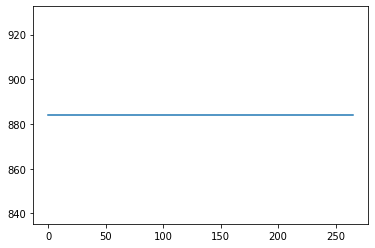

In [6]:
#count not null
plt.plot(np.sum(df.notnull().values, axis=0))

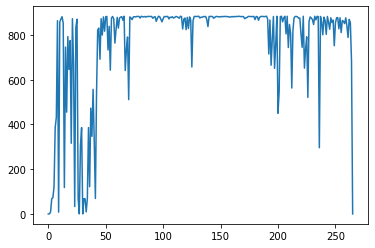

In [7]:
#count zeros per column
plt.plot(np.sum((df == 0).values, axis=0))

In [8]:
X = df.iloc[:, :-1].values
y = LabelEncoder().fit_transform(df.iloc[:, -1].values)

In [9]:
# train test split
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size=0.3, random_state=10)

# Random Grid Search CV -- Model Selection and Parameter Tuning

In [22]:
params1 = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}
params2 = {
        'C': [0.5,0.6,0.8,1.0]
}
param_comb1 = 6
param_comb2 = 4
def get_random_search(model,params,param_comb):
    clf = model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(clf, 
                                       param_distributions=params, 
                                       n_iter=param_comb, 
                                       scoring='roc_auc', 
                                       n_jobs=4, 
                                       cv=cv.split(x_train,y_train), 
                                       verbose=3, 
                                       random_state=42)
    return random_search

In [23]:
model1 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc')
model2 = LogisticRegression()

In [16]:
random_search1 = get_random_search(model1,params1,param_comb1)
random_search1.fit(x_train,y_train)
print(random_search1.best_score_)
print(random_search1.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0.8972298737417801
{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.8}


In [26]:
random_search2 = get_random_search(model2,params2,param_comb2)
random_search2.fit(x_train,y_train)
print(random_search2.best_score_)
print(random_search2.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.7774812382420544
{'C': 0.8}


In [27]:
pd.DataFrame(random_search1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.045467,0.037425,0.013331,0.001267,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.844948,0.856852,0.889856,0.863885,0.018996,3
1,4.502364,0.155232,0.013668,0.000308,1,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.881098,0.896196,0.914396,0.897230,0.013614,1
2,5.375883,0.057307,0.012637,0.000094,0.8,10,3,5,1,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.829051,0.856707,0.866457,0.850738,0.015844,4
3,3.298702,0.015413,0.018458,0.001846,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.822735,0.848722,0.861892,0.844450,0.016269,5
4,3.345170,0.064633,0.014104,0.000891,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.822735,0.848722,0.861892,0.844450,0.016269,5
5,3.940258,0.478293,0.008173,0.002043,1,5,5,1.5,0.6,"{'subsample': 1.0, 'min_child_weight': 5, 'max...",0.876161,0.881533,0.901412,0.886369,0.010861,2


In [28]:
pd.DataFrame(random_search2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.210919,0.052674,0.002501,0.000057,0.5,{'C': 0.5},0.716899,0.845383,0.727208,0.763163,0.058290,2
1,0.185871,0.067123,0.005869,0.004753,0.6,{'C': 0.6},0.748258,0.820412,0.713939,0.760870,0.044373,3
2,0.191652,0.031229,0.006070,0.002888,0.8,{'C': 0.8},0.759872,0.860772,0.711799,0.777481,0.062080,1
3,0.145661,0.022102,0.002322,0.000625,1,{'C': 1.0},0.769744,0.817654,0.656727,0.748042,0.067467,4


# Test on Raw Features

In [32]:
clf1 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc',subsample= 1.0, min_child_weight= 1, max_depth= 3, gamma= 2, colsample_bytree= 0.8)
clf1.fit(x_train,y_train)
y_predict = clf1.predict(x_test)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['notchurn','churn']))

              precision    recall  f1-score   support

    notchurn       0.90      1.00      0.95       212
       churn       0.97      0.57      0.72        54

    accuracy                           0.91       266
   macro avg       0.94      0.78      0.83       266
weighted avg       0.92      0.91      0.90       266



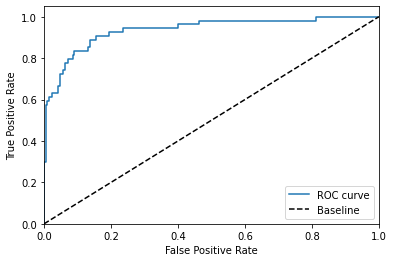

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
y_predict_ = clf1.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_[:,1])
auc_bags_XGB=auc(fpr, tpr)
logloss_bags_XGB=log_loss(y_test, y_predict_[:,1])
plt.plot(fpr, tpr, "C0", label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

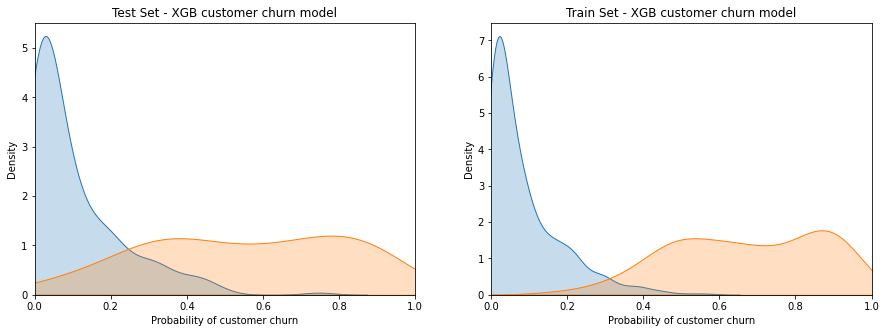

In [38]:
import seaborn as sns
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.kdeplot(clf1.predict_proba(x_train[y_train==0])[:,1],shade=True,label='back',ax=ax[1])
sns.kdeplot(clf1.predict_proba(x_train[y_train==1])[:,1],shade=True,label='not back',ax=ax[1])
ax[1].set_title('Train Set - XGB customer churn model')
sns.kdeplot(clf1.predict_proba(x_test[y_test==0])[:,1],shade=True,label='back',ax=ax[0])
sns.kdeplot(clf1.predict_proba(x_test[y_test==1])[:,1],shade=True,label='not back',ax=ax[0])
ax[0].set_title('Test Set - XGB customer churn model')
for i in [0,1]:
    ax[i].set_xlim(0,1)
    #ax[i].set_ylim(0,4)
    ax[i].set_ylabel('Density')
    ax[i].set_xlabel('Probability of customer churn')

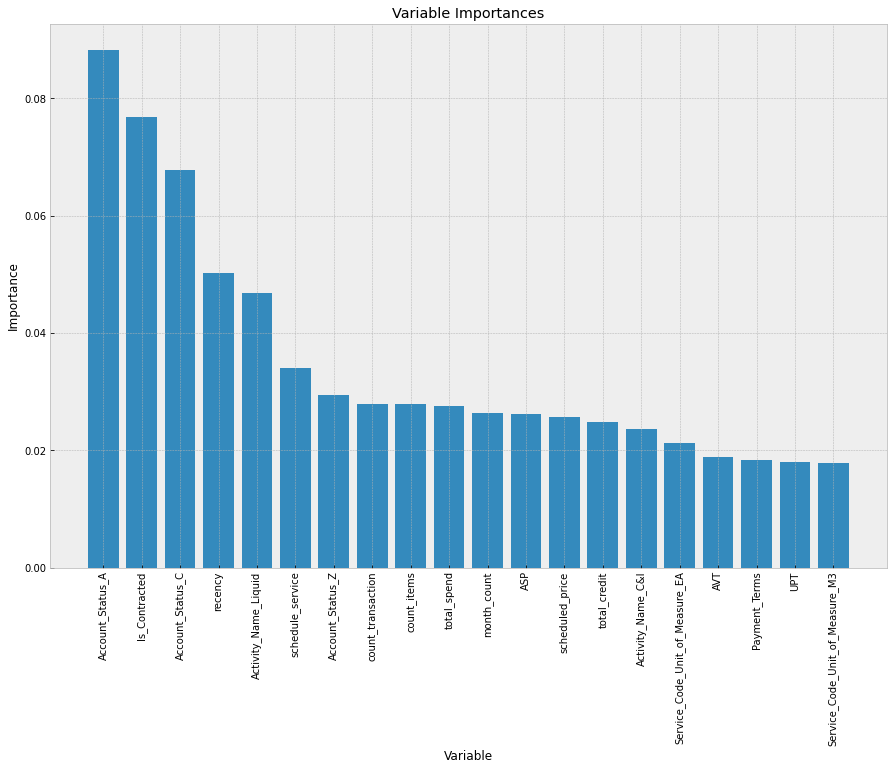

In [51]:
import operator
from matplotlib.pyplot import figure
f_imp = clf1.feature_importances_
df_importance = pd.DataFrame()
df_importance['name'] = df.columns[:-1]
df_importance['importance'] = f_imp
df_importance_ = df_importance.sort_values(by='importance', ascending=False).iloc[0:20,:]

# Make a bar chart
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range((df_importance_.shape[0])))
plt.figure(figsize=(15,10))
plt.bar(df_importance_['name'], df_importance_['importance'], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, df_importance_['name'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Test on Features removing Account Status

In [55]:
not_account_status_idxs = ['Account_Status' not in col for col in df.columns[:-1]]
X_remove_status = x_train[:, not_account_status_idxs]
X_test_remove_status = x_test[:, not_account_status_idxs]

In [53]:

random_search3 = get_random_search(model1,params1,param_comb1)
random_search3.fit(X_remove_status,y_train)
print(random_search3.best_score_)
print(random_search3.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0.891933340281979
{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.8}


In [54]:
pd.DataFrame(random_search3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.761470,0.136098,0.015274,0.001753,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.831156,0.847851,0.874304,0.851104,0.017765,3
1,4.482935,0.087620,0.009505,0.003150,1,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.878920,0.887050,0.909830,0.891933,0.013083,1
2,5.222595,0.019974,0.012877,0.000343,0.8,10,3,5,1,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.813661,0.829268,0.848623,0.830518,0.014300,4
3,3.236434,0.017463,0.011435,0.003266,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.810830,0.834350,0.844628,0.829936,0.014146,5
4,3.296285,0.045492,0.013676,0.000111,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.810830,0.834350,0.844628,0.829936,0.014146,5
5,3.743246,0.552068,0.007306,0.000817,1,5,5,1.5,0.6,"{'subsample': 1.0, 'min_child_weight': 5, 'max...",0.871951,0.873839,0.895706,0.880498,0.010781,2


In [57]:
clf2 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc',subsample= 1.0, min_child_weight= 1, max_depth= 3, gamma= 2, colsample_bytree= 0.8)
clf2.fit(X_remove_status,y_train)
y_predict2 = clf2.predict(X_test_remove_status)

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict2, target_names=['notchurn','churn']))

              precision    recall  f1-score   support

    notchurn       0.91      0.98      0.94       212
       churn       0.89      0.61      0.73        54

    accuracy                           0.91       266
   macro avg       0.90      0.80      0.83       266
weighted avg       0.90      0.91      0.90       266



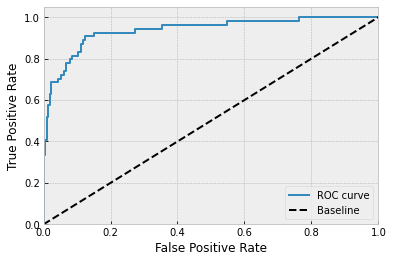

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
y_predict_1 = clf2.predict_proba(X_test_remove_status)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_1[:,1])
auc_bags_XGB=auc(fpr, tpr)
logloss_bags_XGB=log_loss(y_test, y_predict_1[:,1])
plt.plot(fpr, tpr, "C0", label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

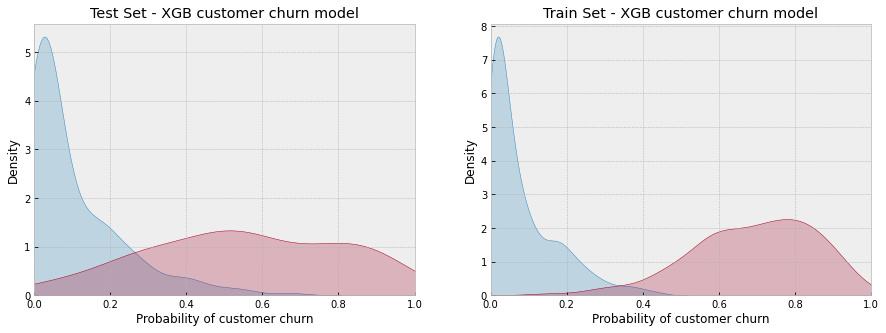

In [61]:
import seaborn as sns
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.kdeplot(clf2.predict_proba(X_remove_status[y_train==0])[:,1],shade=True,label='back',ax=ax[1])
sns.kdeplot(clf2.predict_proba(X_remove_status[y_train==1])[:,1],shade=True,label='not back',ax=ax[1])
ax[1].set_title('Train Set - XGB customer churn model')
sns.kdeplot(clf2.predict_proba(X_test_remove_status[y_test==0])[:,1],shade=True,label='back',ax=ax[0])
sns.kdeplot(clf2.predict_proba(X_test_remove_status[y_test==1])[:,1],shade=True,label='not back',ax=ax[0])
ax[0].set_title('Test Set - XGB customer churn model')
for i in [0,1]:
    ax[i].set_xlim(0,1)
    #ax[i].set_ylim(0,4)
    ax[i].set_ylabel('Density')
    ax[i].set_xlabel('Probability of customer churn')

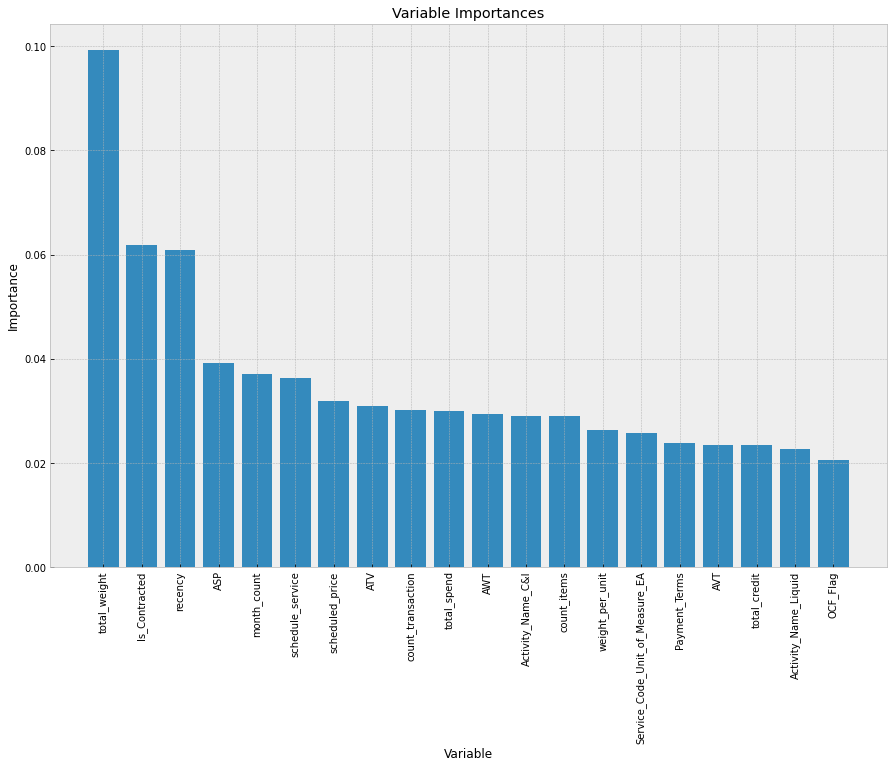

In [83]:
import operator
from matplotlib.pyplot import figure
f_imp = clf2.feature_importances_
df_importance = pd.DataFrame()
df_importance['name'] = df.iloc[:, :-1].loc[:, not_account_status_idxs].columns
df_importance['importance'] = f_imp
df_importance_ = df_importance.sort_values(by='importance', ascending=False).iloc[0:20,:]

# Make a bar chart
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range((df_importance_.shape[0])))
plt.figure(figsize=(15,10))
plt.bar(df_importance_['name'], df_importance_['importance'], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, df_importance_['name'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Test on Data after Feature Selection

In [85]:
# get a list of models to evaluate

def get_models():
	models = dict()
	for i in [30,40,50,60,70]:
		rfe = RFE(estimator=XGBClassifier(use_label_encoder=False, eval_metric='auc'), n_features_to_select=i)
		model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc',subsample= 1.0, min_child_weight= 1, max_depth= 3, gamma= 2, colsample_bytree= 0.8)
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_remove_status,y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>30 0.890 (0.013)
>40 0.887 (0.014)
>50 0.890 (0.012)
>60 0.888 (0.014)
>70 0.889 (0.011)


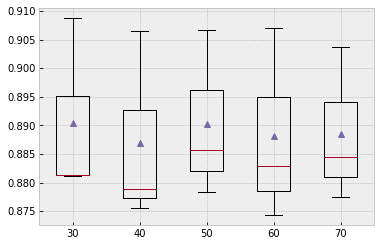

In [87]:
from matplotlib import pyplot
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [91]:
from sklearn.feature_selection import RFE
rfe = RFE(XGBClassifier(use_label_encoder=False, eval_metric='auc'), n_features_to_select=50)
X_rfe = rfe.fit_transform(X_remove_status,y_train)
# summarize all features and generate the selection array
for i in range(X_remove_status.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 5.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 6.000
Column: 12, Selected False, Rank: 19.000
Column: 13, Selected False, Rank: 20.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 14.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected False, Rank: 16.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected True, Rank: 1.000
Column: 23, Selected True, Rank: 1.000
Column: 24, Selected False, Rank: 29.000
Column: 25, Selected F

In [93]:
X_remove_status_fs = X_remove_status[:,rfe.support_]
X_test_remove_status_fs = X_test_remove_status[:,rfe.support_]

In [94]:
random_search4 = get_random_search(model1,params1,param_comb1)
random_search4.fit(X_remove_status_fs,y_train)
print(random_search4.best_score_)
print(random_search4.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0.8908837246862573
{'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 2, 'colsample_bytree': 0.8}


In [96]:
clf3 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc',subsample= 1.0, min_child_weight= 1, max_depth= 3, gamma= 2, colsample_bytree= 0.8)
clf3.fit(X_remove_status_fs,y_train)
y_predict3 = clf3.predict(X_test_remove_status_fs)

In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict3, target_names=['notchurn','churn']))

              precision    recall  f1-score   support

    notchurn       0.90      0.98      0.94       212
       churn       0.89      0.59      0.71        54

    accuracy                           0.90       266
   macro avg       0.90      0.79      0.83       266
weighted avg       0.90      0.90      0.89       266



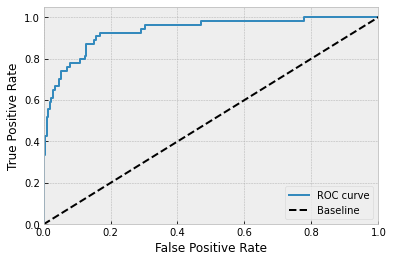

In [98]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
y_predict_2 = clf3.predict_proba(X_test_remove_status_fs)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_2[:,1])
auc_bags_XGB=auc(fpr, tpr)
logloss_bags_XGB=log_loss(y_test, y_predict_2[:,1])
plt.plot(fpr, tpr, "C0", label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

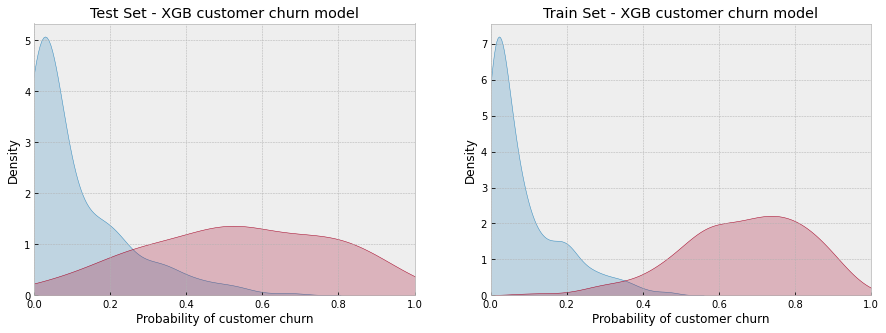

In [99]:
import seaborn as sns
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.kdeplot(clf3.predict_proba(X_remove_status_fs[y_train==0])[:,1],shade=True,label='back',ax=ax[1])
sns.kdeplot(clf3.predict_proba(X_remove_status_fs[y_train==1])[:,1],shade=True,label='not back',ax=ax[1])
ax[1].set_title('Train Set - XGB customer churn model')
sns.kdeplot(clf3.predict_proba(X_test_remove_status_fs[y_test==0])[:,1],shade=True,label='back',ax=ax[0])
sns.kdeplot(clf3.predict_proba(X_test_remove_status_fs[y_test==1])[:,1],shade=True,label='not back',ax=ax[0])
ax[0].set_title('Test Set - XGB customer churn model')
for i in [0,1]:
    ax[i].set_xlim(0,1)
    #ax[i].set_ylim(0,4)
    ax[i].set_ylabel('Density')
    ax[i].set_xlabel('Probability of customer churn')

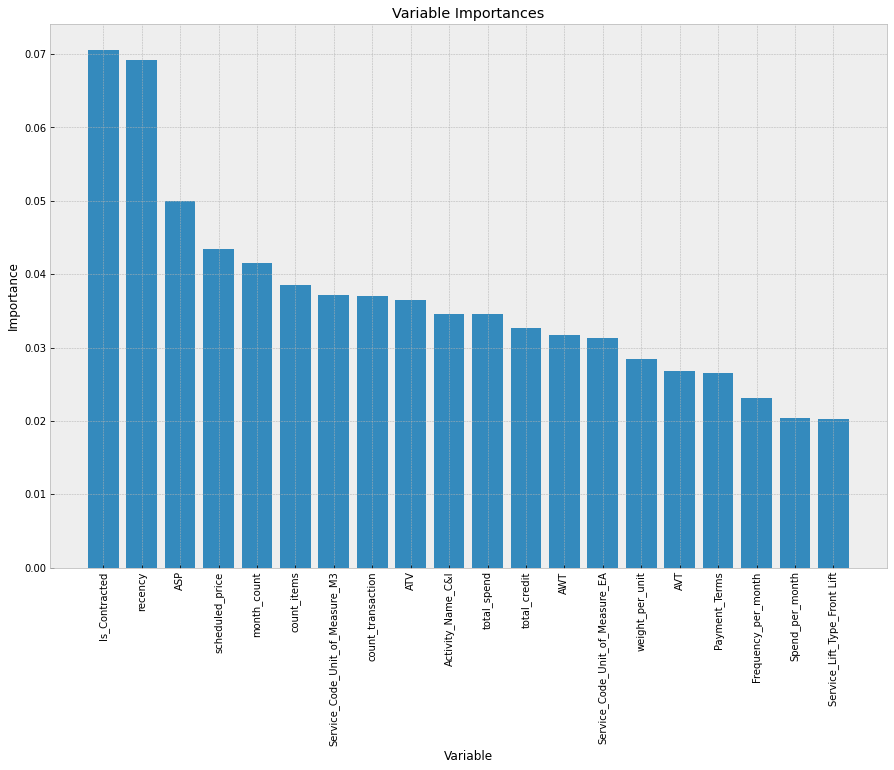

In [103]:
import operator
from matplotlib.pyplot import figure
f_imp = clf3.feature_importances_
df_importance = pd.DataFrame()
df_importance['name'] = df.iloc[:, :-1].loc[:, not_account_status_idxs].loc[:, rfe.support_].columns
df_importance['importance'] = f_imp
df_importance_ = df_importance.sort_values(by='importance', ascending=False).iloc[0:20,:]

# Make a bar chart
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range((df_importance_.shape[0])))
plt.figure(figsize=(15,10))
plt.bar(df_importance_['name'], df_importance_['importance'], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, df_importance_['name'], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Partial dependency plot

In [110]:
df_rfe.columns

Index(['count_transaction', 'count_items', 'total_spend', 'total_credit',
       'total_vol', 'total_weight', 'scheduled_price',
       'Service_Code_Unit_of_Measure_EA', 'Service_Code_Unit_of_Measure_HR',
       'Service_Code_Unit_of_Measure_M3', 'Service_Lift_Type_Front Lift',
       'Service_Lift_Type_Rear Lift', 'Service_Waste_Stream_Co-Mingle',
       'Service_Waste_Stream_General Waste', 'Service_Waste_Stream_Organic',
       'Service_Waste_Stream_Recycling', 'Activity_Name_C&I',
       'Activity_Name_Sale of Other', 'month_count', 'recency',
       'weight_per_unit', 'Frequency_per_month', 'Spend_per_month', 'ATV',
       'UPT', 'ASP', 'AWT', 'AVT', 'OCF_Flag', 'PIF_Flag', 'Payment_Terms',
       'Is_Contracted', 'Lead_Source_E', 'Billing_Cycle_M4O',
       'Billing_Cycle_MEO', 'Billing_Address_State_NT',
       'Billing_Address_State_VIC', 'Account_Type_C', 'Account_Type_INT',
       'Account_Type_LAN', 'Account_Type_ST', 'Sub_Banding_Inside Sales',
       'Uprate_Category_GEN'

In [134]:
df_rfe = pd.DataFrame(X_remove_status_fs,columns = df[df.columns[:-1][not_account_status_idxs][rfe.support_]].columns)
top_30 = df_importance.sort_values(by='importance', ascending=False).iloc[0:30,:]['name']

In [135]:
clf4 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1,use_label_encoder=False,eval_metric='auc',subsample= 1.0, min_child_weight= 1, max_depth= 3, gamma= 2, colsample_bytree= 0.8)
clf4.fit(df_rfe,y_train)

XGBClassifier(colsample_bytree=0.8, eval_metric='auc', gamma=2,
              learning_rate=0.02, n_estimators=600, nthread=1, subsample=1.0,
              use_label_encoder=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


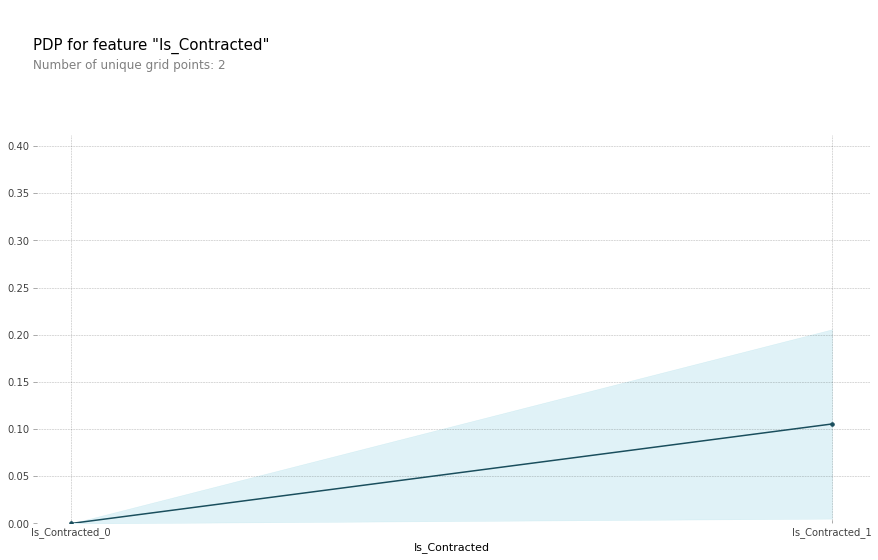

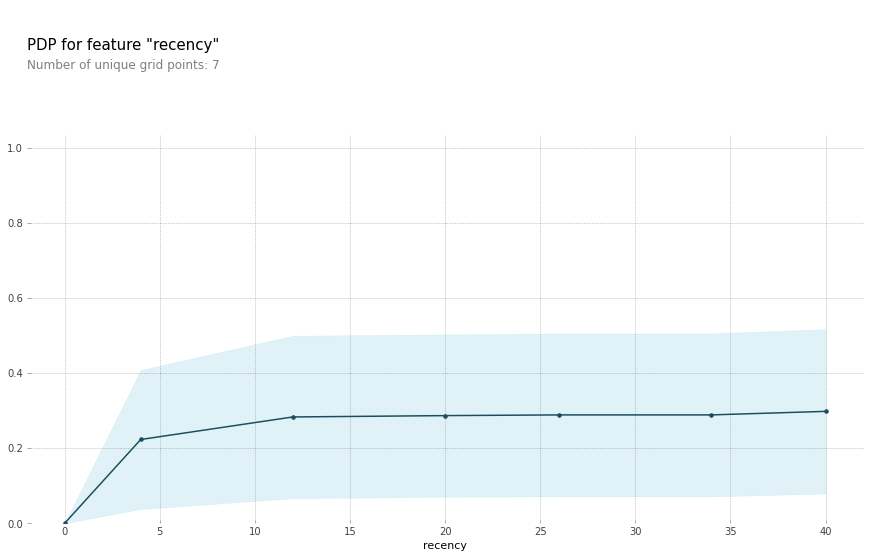

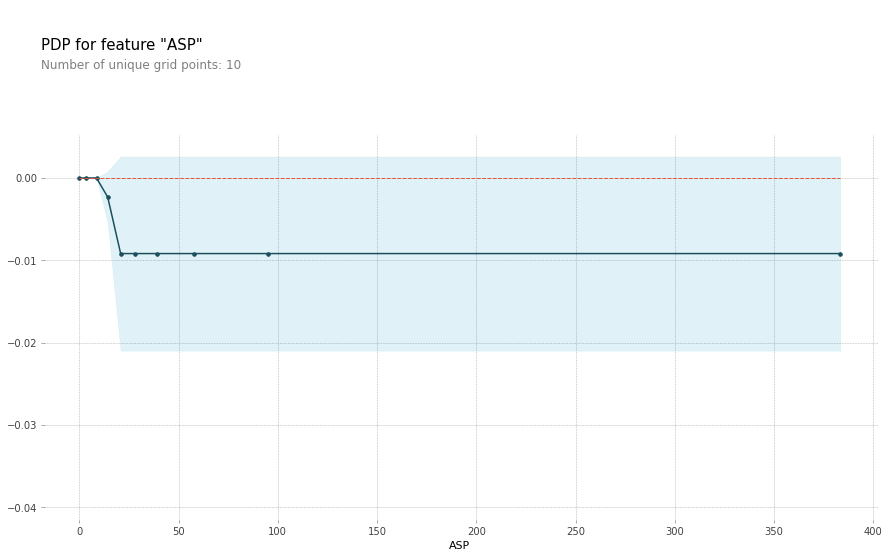

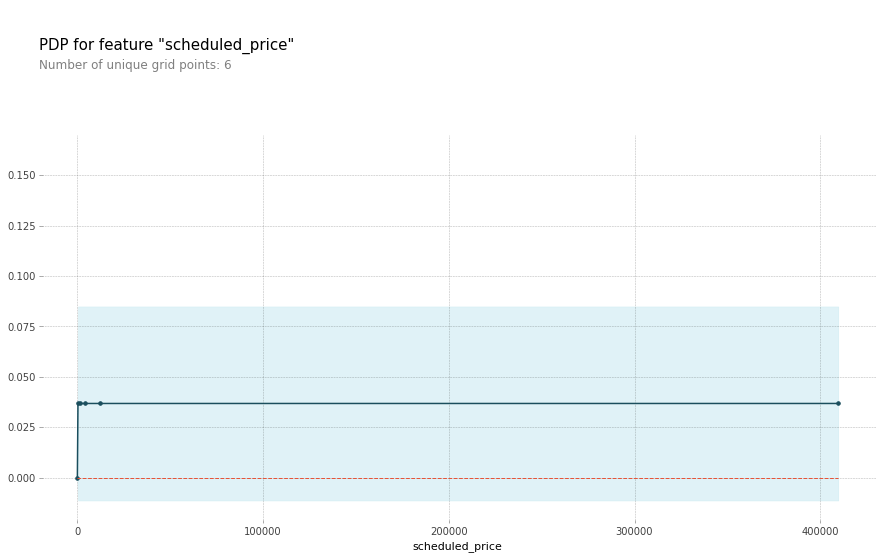

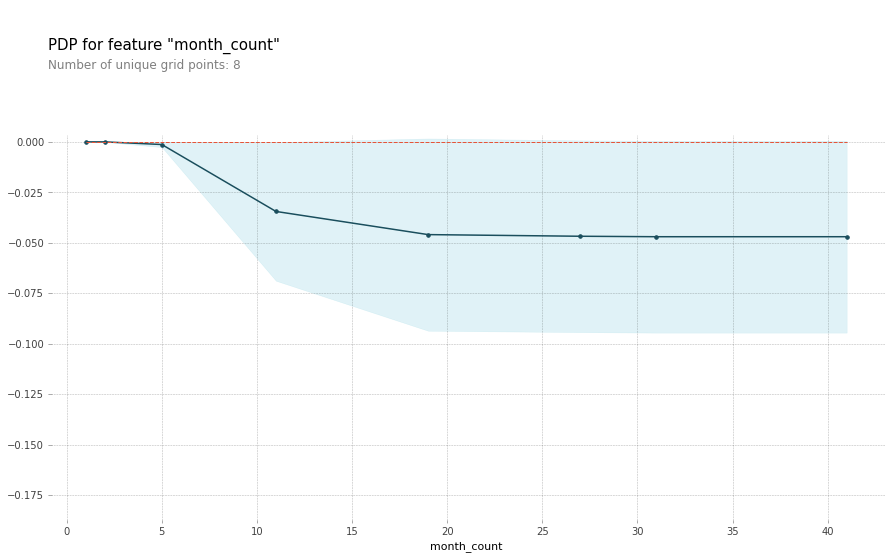

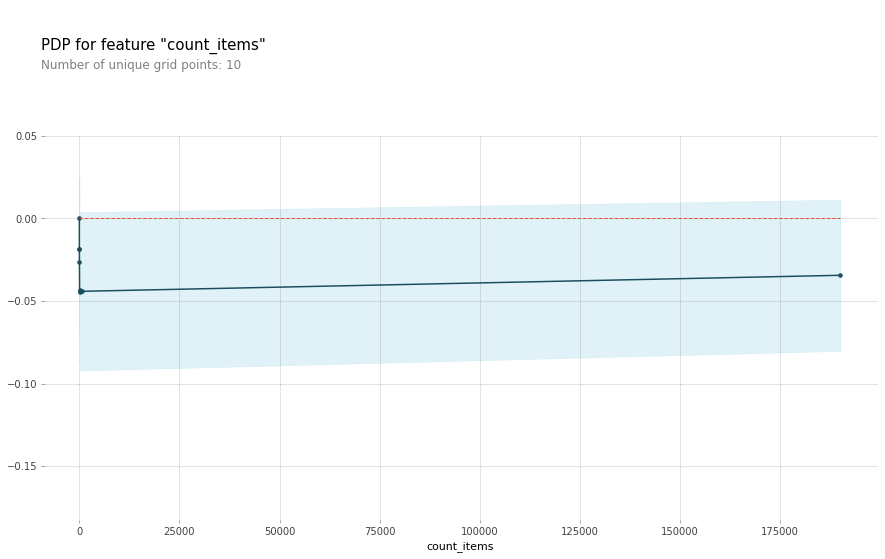

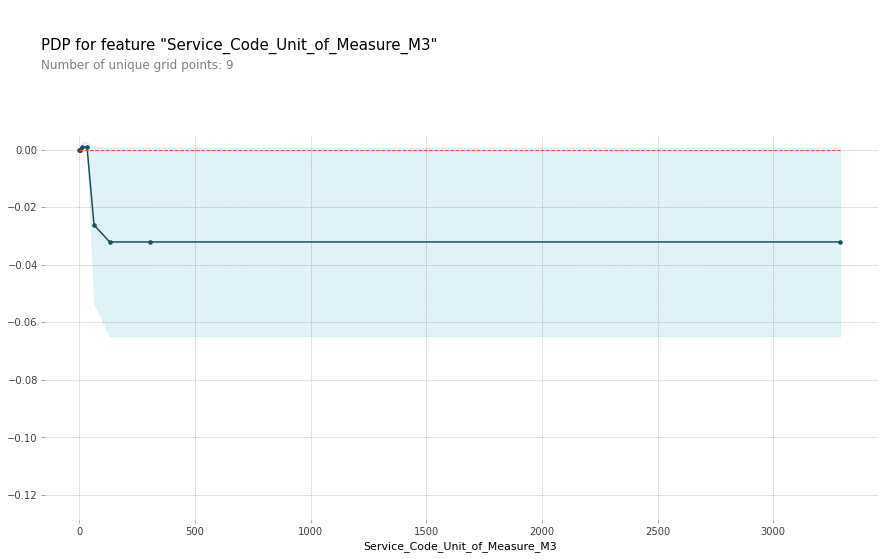

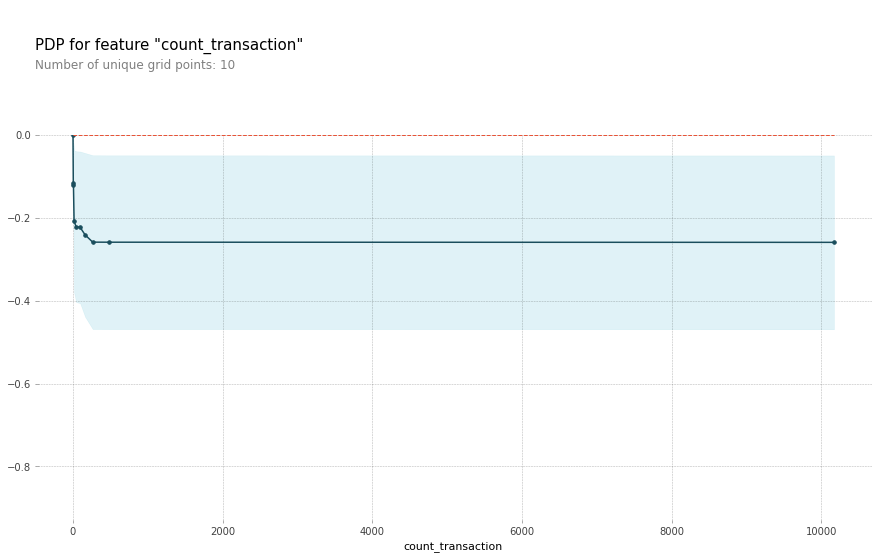

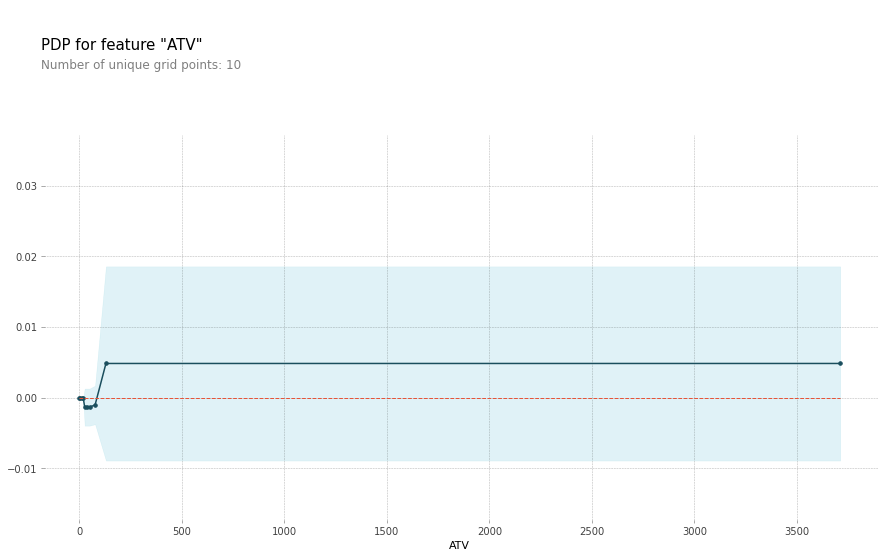

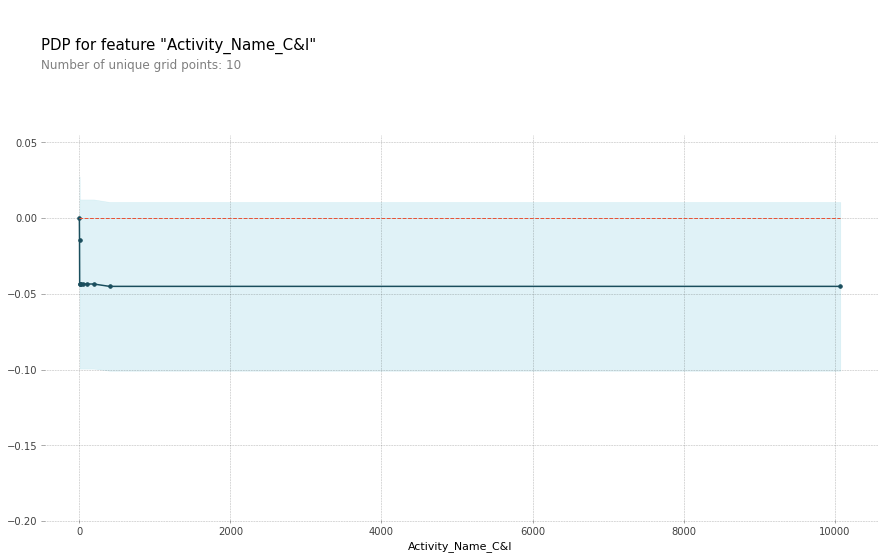

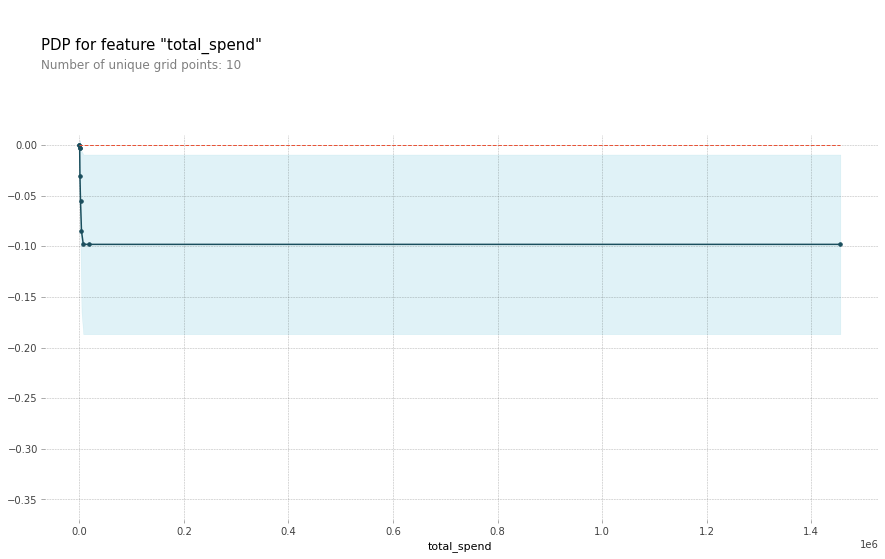

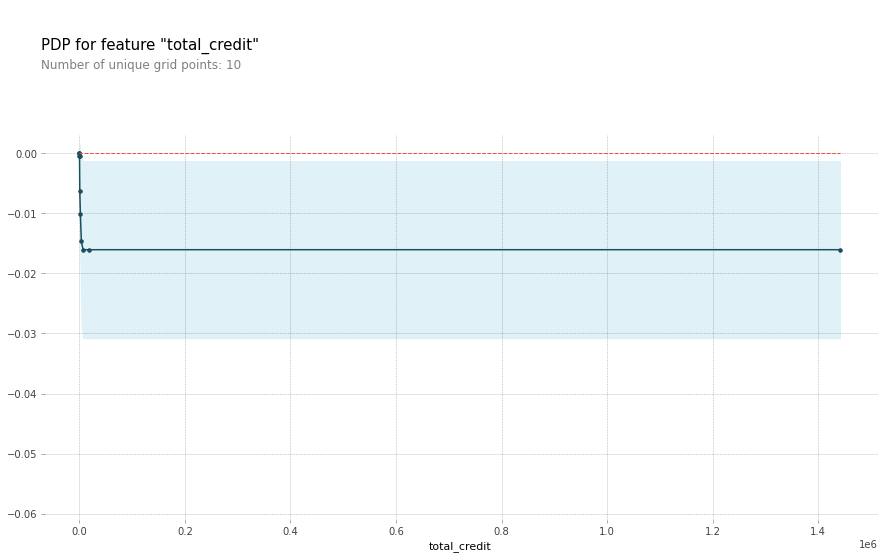

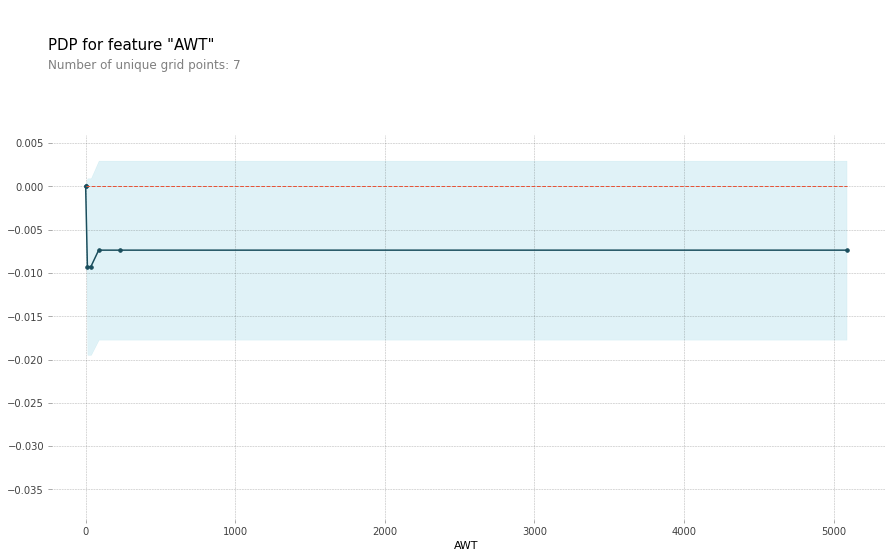

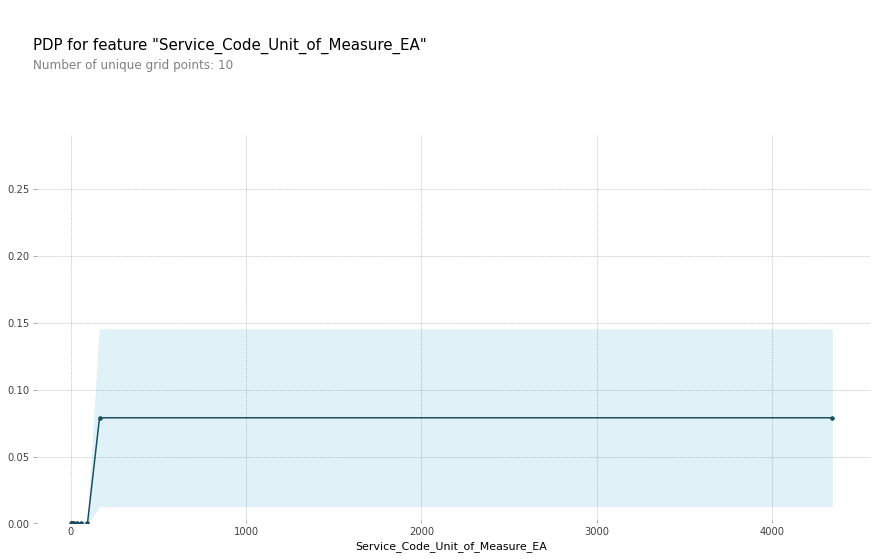

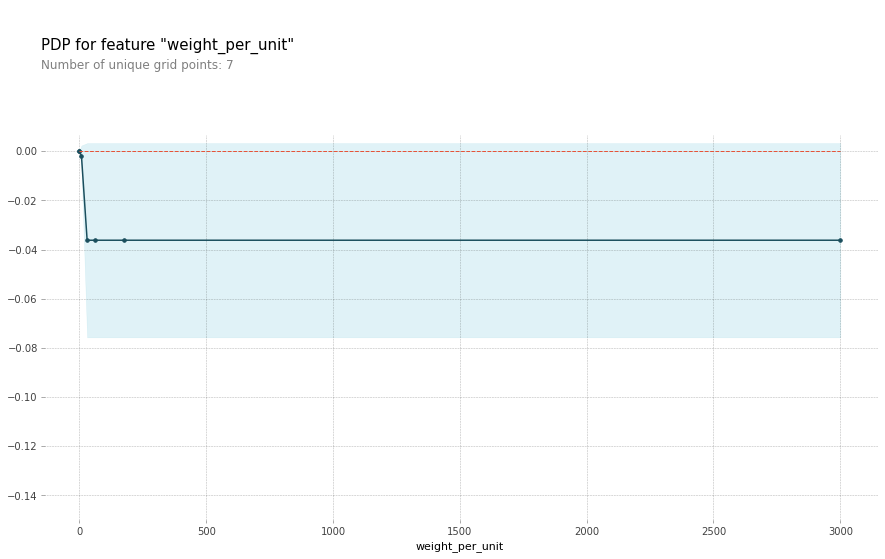

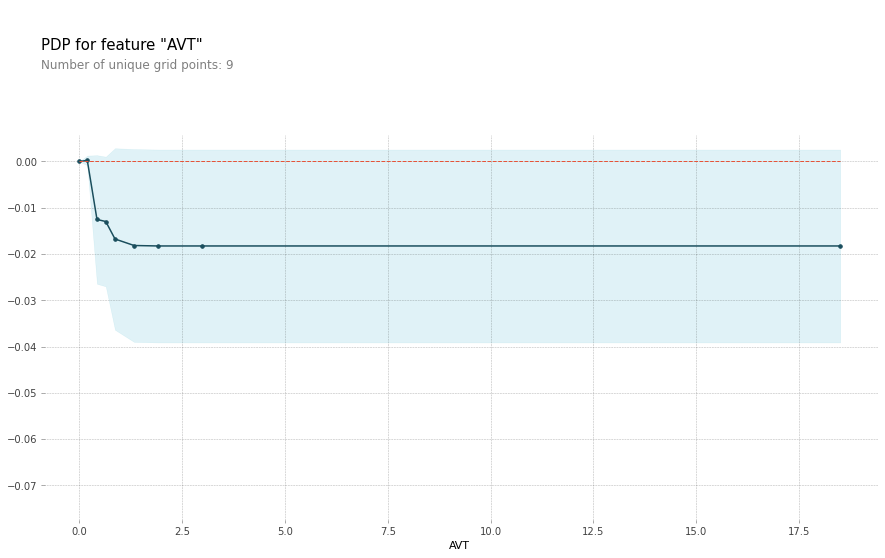

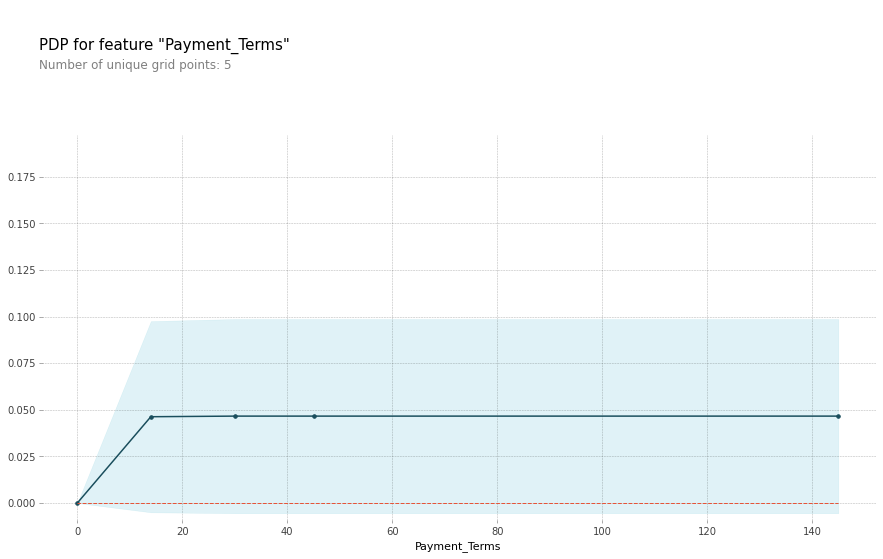

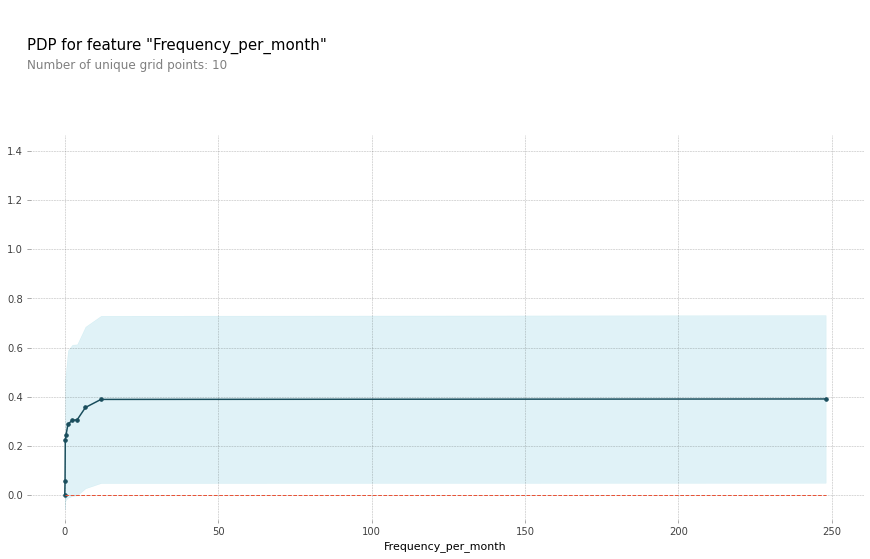

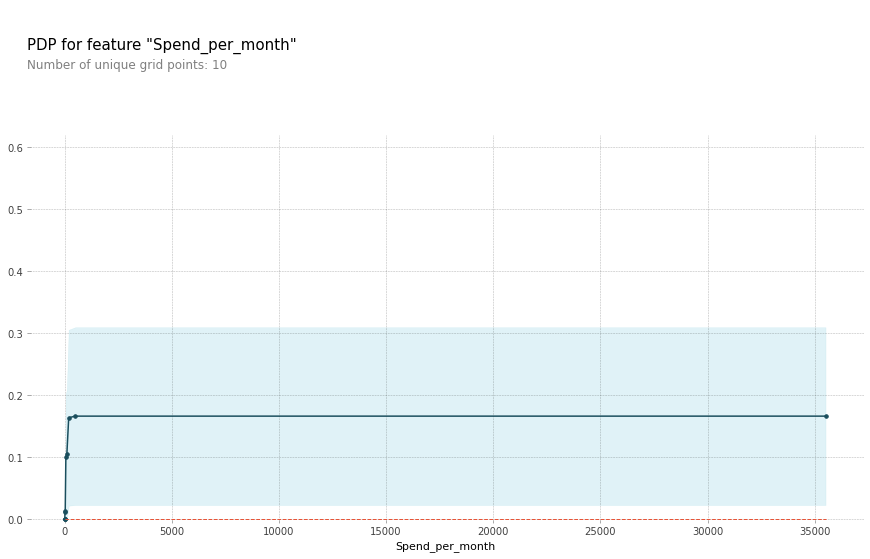

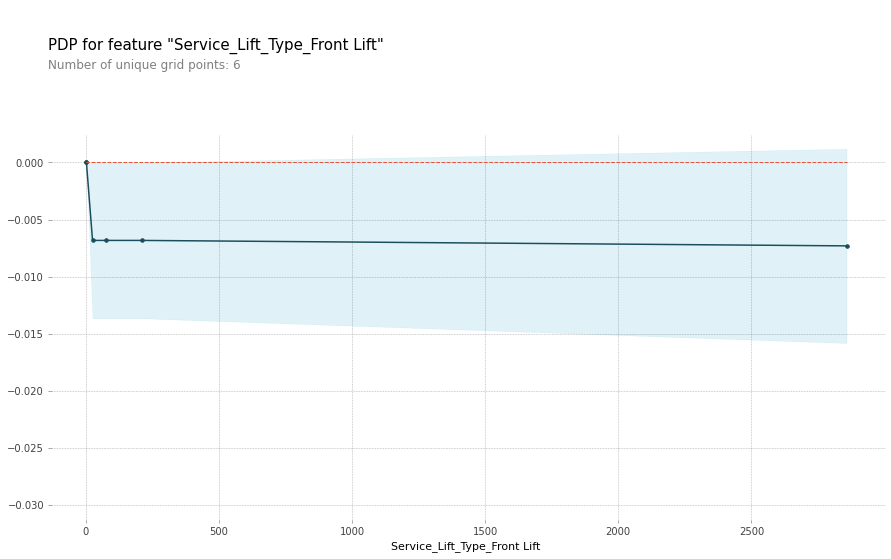

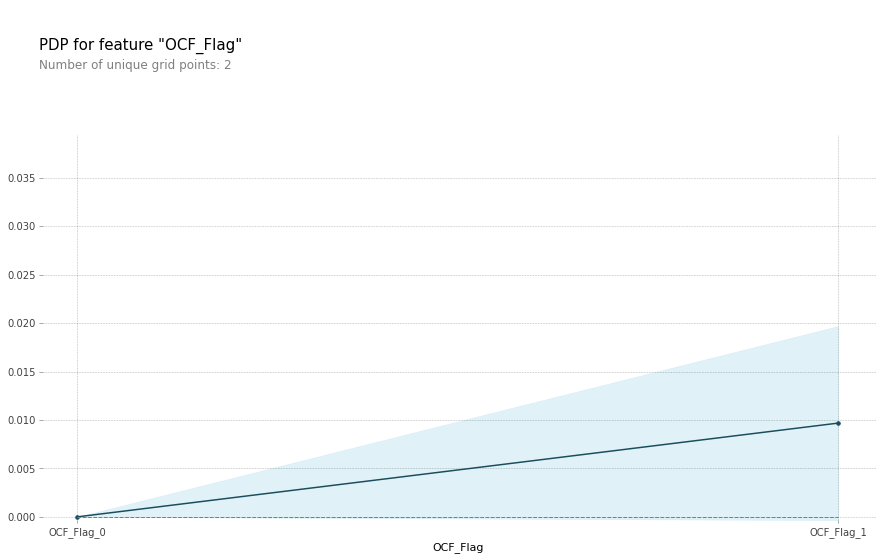

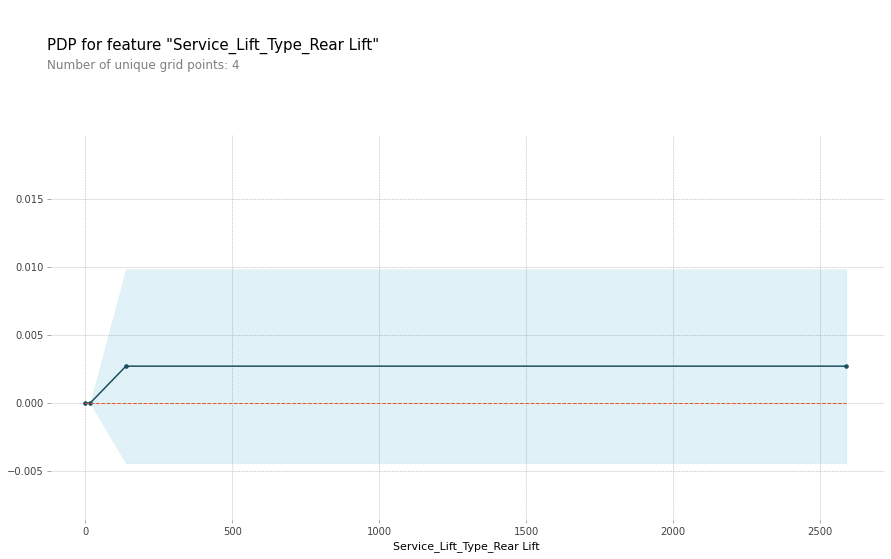

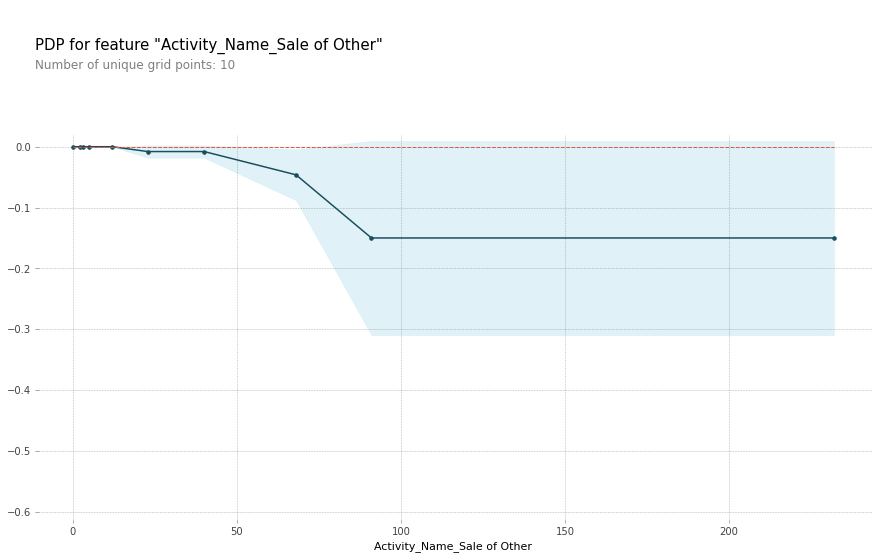

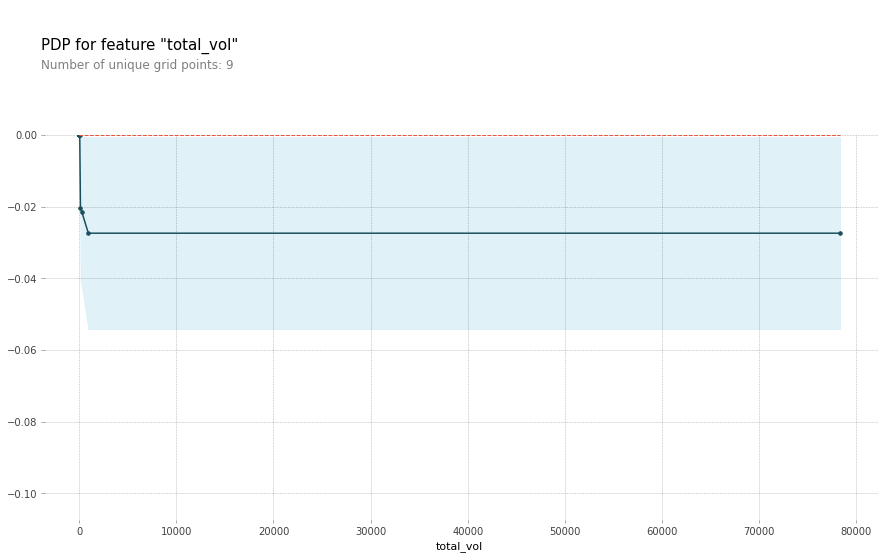

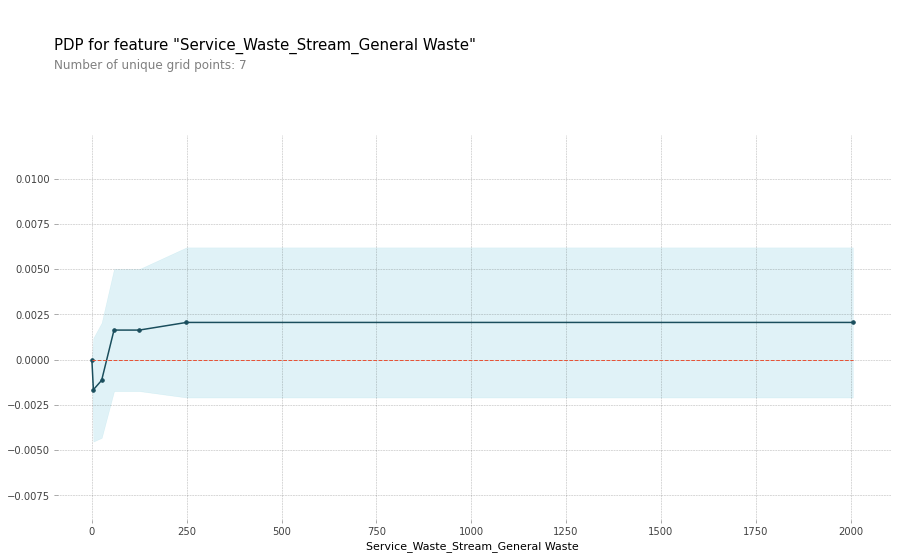

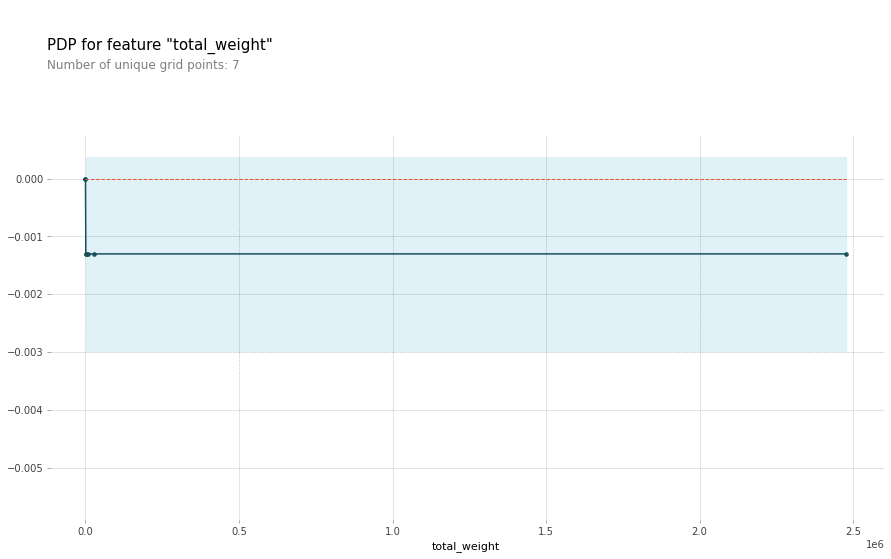

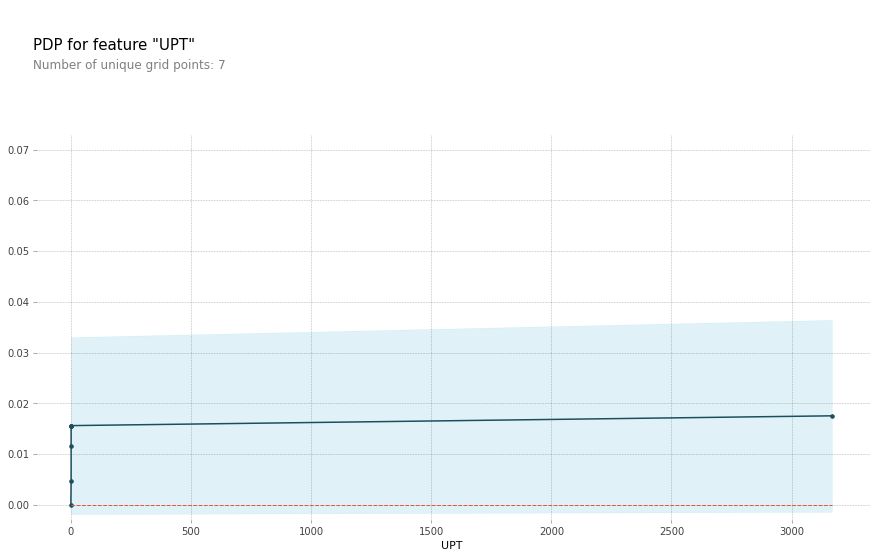

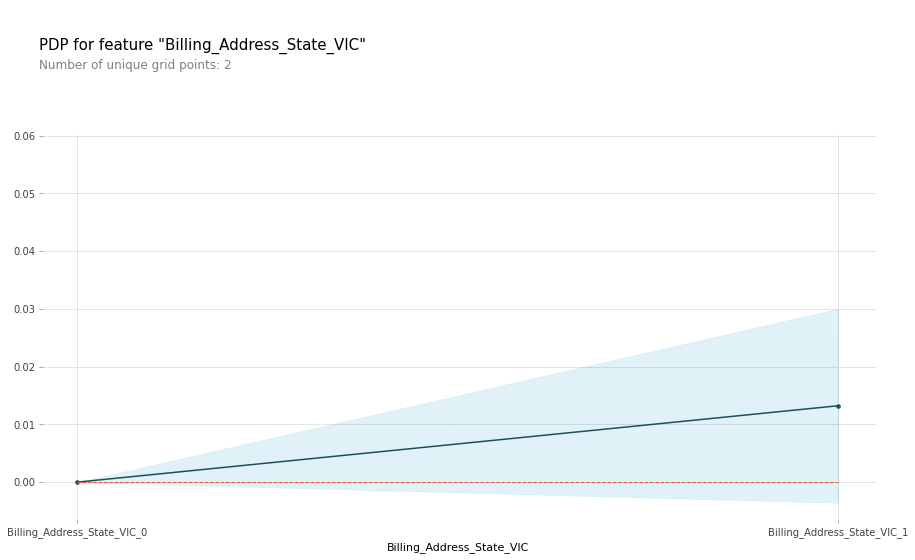

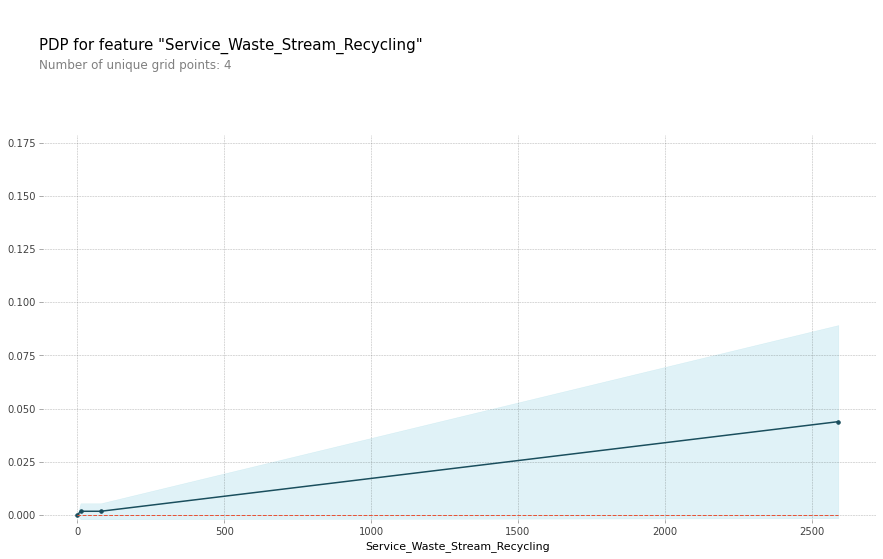

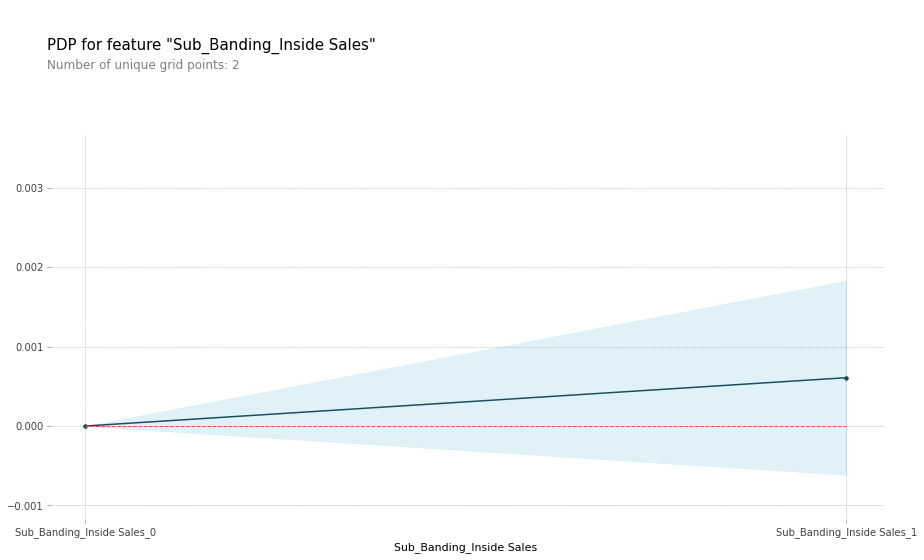

In [136]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

for i in top_30:
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=clf4, dataset=df_rfe, model_features=list(df_rfe.columns), feature=i)
    # plot it
    pdp.pdp_plot(pdp_goals, i)
    plt.show()

# LIME instance explain

In [142]:
import lime
import lime.lime_tabular
cat_idx = np.arange(len(df_rfe.columns))[df_rfe.nunique() == 2]

# create explainer
explainer = lime.lime_tabular.LimeTabularExplainer(df_rfe.values, mode = 'classification', feature_names=list(df_rfe.columns),
                                                   categorical_features = cat_idx)

In [155]:
# explain on selected instance
x= df_rfe.iloc[8]
exp = explainer.explain_instance(x, random_search4.best_estimator_.predict_proba, num_features=6,top_labels=4)

In [156]:
# show the explain on selected instance
exp.show_in_notebook(show_table=True, show_all=True)

In [151]:
p = clf4.predict(df_rfe)

In [152]:
p

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,